__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 07, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates or returns values for a calculation. Use the cells below functions to run functions and save figures to the __Figures/Operator_evolution__ folder.

__Revision history:<br/>__
* Jan 07, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb. Note, some of these notebooks could be in Old_codes.
* Jan 22, 2020 - Added universality_test function.
* Feb 05, 2020 - Added functions that look at the SRG unitary transformations directly.
* Feb 26, 2020 - Updating functionality of the notebook. Functions will now return f, ax. Add extra labels outside the functions in cells below.
* Apr 09, 2020 - Added function that looks at ratio of SRG transformations to see factorization.
* May 11, 2020 - Changed the SRG transformation contours function to look at generators simultaneously getting rid of the log-scale row.
* Jun 02, 2020 - Using smeared $\delta$ functions in $a^{\dagger}_q a_q$.

In [1]:
from os import chdir, getcwd
import math
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
%matplotlib inline
from numpy import linalg as la
import numpy as np
from scipy.linalg import expm
from scipy.special import spherical_jn
# Scripts made by A.T.
from Figures import figures_functions as ff
from Figures import register_colormap
import observables as ob
import operators as op
from Potentials.vsrg_macos import load_save_potentials as lsp
from Potentials.vsrg_macos import sdt_funcs as sdt
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Variables and constants__

In [2]:
# Current working directory
cwd = getcwd()

# kvnns
# EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm
kvnns_default = (79, 111, 222)
# Non-local LO \Lambda = 4, 9, 20 fm^-1
kvnns_high_cutoffs = (900, 901, 902)

# Partial wave channels for universality test functions
channels = ('1S0', '3S1', '1P1', '1F3', '1G4')

# SRG generators and lambda values for momentum distribution plots - (generator, lambda, lambda_bd)
wegner_1_5 = ('Wegner', 1.5)
block_diag_2 = ('Block-diag', 1.5, 2.00)
block_diag_3 = ('Block-diag', 1.5, 3.00)

# SRG generators
generators = ('Wegner', 'Block-diag')
generators_magnus = ('Wegner', 'T')

# k values for Magnus truncation
k_magnus_values = (2, 6, 10)

# k values for factorization test
k_points = np.array( [0.5, 1.0, 1.5, 3.0] )

__Plot phase shifts $\delta(k)$__

In [3]:
def phase_shifts(channel, kvnns):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
     
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47
    
    # Max relative momentum in fm^-1
    k_max = 4.0
    # Number of points in momentum array
    m = 200
    # Create momentum array
    k_points = np.linspace(0.01, k_max, m)
    # We could also plot phase shifts with respect to E_lab but choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2
    
    # Coupled-channel (boolean variable) 
    coupled_channel = lsp.coupled_channel(channel)
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # x-axis limit
    xlim = [0.0, k_max]
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate phase shifts --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Load momentum, weights, and potential
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        V_matrix = lsp.load_potential(kvnn, channel)

        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
            
        # Store in dictionary with kvnn as key
        d[kvnn] = delta_array
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
        
        # Add curve to figure
        ax.plot(k_points, d[kvnn], color=curve_color, label=curve_label, linestyle=curve_style, 
                linewidth=curve_width)

    # Specify x-axis limit
    ax.set_xlim(xlim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [4]:
# # Phase shifts for EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm)
# channel = '3S1'
# f, ax = phase_shifts(channel, kvnns_default)

# # Set the y-axis limit (this will vary based on partial wave channel)
# ylim = [-50.0, 180.0]
# ax.set_ylim(ylim)

# # Add legend for kvnns
# legend_size = 16
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add channel label
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 22
# channel_label_location = 'lower left'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'phase_shifts_%s_kvnns' % channel
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot momentum distributions $\psi_{\alpha}(k)^2$__

In [5]:
def deuteron_momentum_distribution(kvnn, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * np.sqrt(2/np.pi)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution
    psi_squared_initial = u_initial**2 + w_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\psi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function in units fm^3
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution
        psi_squared_evolved = u_evolved**2 + w_evolved**2
            
        # Store in dictionary with gen as key
        d[gen] = psi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb)
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, psi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [6]:
# # Deuteron momentum distributions with RKE N4LO (450 MeV) and band- and block-diagonal SRG evolution
# kvnn = 111
# f, ax = deuteron_momentum_distribution(kvnn, wegner_1_5, block_diag_2, block_diag_3)

# # Add legend for kvnns
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Set file name
# file_name = 'deuteron_momentum_distributions_kvnn%d.pdf' % kvnn 

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [7]:
def high_energy_state_momentum_distribution(eps, kvnn, channel, *generators):
    """
    Plots a high-energy state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigenenergy of the state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Coupled-channel (boolean variable) 
    coupled_channel = lsp.coupled_channel(channel)
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    if coupled_channel:
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    else:
        factor_array = np.sqrt( (2 * k_weights) / np.pi ) * k_array
    H_initial = lsp.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    
    # Initial momentum distribution
    if coupled_channel:
        u_initial = psi_initial[:ntot]
        w_initial = psi_initial[ntot:]
        psi_squared_initial = u_initial**2 + w_initial**2
    else:
        psi_squared_initial = psi_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limiits
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e1]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\psi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function and evolved momentum distributions
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        
        # Evolved momentum distribution
        if coupled_channel:
            u_evolved = psi_evolved[:ntot]
            w_evolved = psi_evolved[ntot:]
            psi_squared_evolved = u_evolved**2 + w_evolved**2
        else:
            psi_squared_evolved = psi_evolved**2
        
        # Store in dictionary with gen as key
        d[gen] = psi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb)
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, psi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [8]:
# # High-energy state (300 MeV) momentum distributions with RKE N4LO (450 MeV) and band- and block-diagonal SRG evolution
# eps = 300.0
# kvnn = 111
# channel = '3S1'
# f, ax = high_energy_state_momentum_distribution(eps, kvnn, channel, wegner_1_5, block_diag_2, block_diag_3)

# # Set file name
# file_name = 'high_energy_state_eps%.1f_momentum_distributions_kvnn%d' % (eps, kvnn)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [9]:
# # Spurious state momentum distributions with \Lambda=9 fm^-1 and band- and block-diagonal SRG evolution
# eps = -2000
# kvnn = 901
# channel = '3S1'
# f, ax = high_energy_state_momentum_distribution(eps, kvnn, channel, ('Wegner', 1.2), ('Block-diag', 1.2, 2.00), 
#                                                 ('Block-diag', 1.2, 2.80))

# # Add legend for kvnns
# legend_size = 14
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
# # Set file name
# file_name = 'spurious_state_momentum_distributions_kvnn%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot potential contours $V_{\lambda}(k,k')$__

In [10]:
def potential_contours_kvnns(channel, generator, kvnns, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of kvnns and n is the size of lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Size of figure
    row_number = len(kvnns)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
#     axes_max = 10.0
    axes_lim = [0.0, axes_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    else:
        mx = 0.4
        mn = -0.4
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    if channel in ['1S0', '3S1']:
        levels_ticks_strings = ['%.2f' % tick for tick in levels_ticks]
    else:
        levels_ticks_strings = ['%.1f' % tick for tick in levels_ticks]
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and potential in here
        d[kvnn] = {} 
        
        # Load momentum
        k_array, _ = lsp.load_momentum(kvnn, channel)
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lsp.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Store in dictionary with kvnn, and 'k_array' or lamb as keys
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over kvnns and lambda's keeping track of indices
    for i, kvnn in enumerate(kvnns):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][lamb], levels, 
                                       cmap=color_style, extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][lamb], cmap=color_style,
                                         vmin=mn, vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [11]:
# # Contours of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm) under Wegner transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([np.inf, 3.0, 2.0, 1.5])
# f, axs = potential_contours_kvnns(channel, generator, kvnns_default, lambda_array)

# # Add kvnn label to each subplot on the last column
# kvnn_label_size = 17
# kvnn_label_location = 'upper right'
# for i, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i in range( len(kvnns_default) ):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_%s_%s_kvnns' % (channel, generator)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [12]:
# # Contours of high cutoff potentials under Wegner transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([2.8, 2.0, 1.2])
# f, axs = potential_contours_kvnns(channel, generator, kvnns_high_cutoffs, lambda_array)

# # Add kvnn label to each subplot on the last column
# kvnn_label_size = 17
# kvnn_label_location = 'upper right'
# for i, kvnn in enumerate(kvnns_high_cutoffs):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i in range( len(kvnns_default) ):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_%s_%s_kvnns' % (channel, generator)
# for kvnn in kvnns_high_cutoffs:
#     file_name += '_%d' % kvnn
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [13]:
def potential_contours_generators(kvnn, channel, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where m is
    the size of generators and n is the size of lambda_array. Analogous to potential_contours_kvnns function but 
    compares SRG generators fixing the NN potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum
    k_array, _ = lsp.load_momentum(kvnn, channel)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    else:
        mx = 0.4
        mn = -0.4
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    if channel in ['1S0', '3S1']:
        levels_ticks_strings = ['%.2f' % tick for tick in levels_ticks]
    else:
        levels_ticks_strings = ['%.1f' % tick for tick in levels_ticks]
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over kvnns
    for generator in generators:
        
        # Store potential in here
        d[generator] = {} 
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = lsp.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [14]:
# # Contours of RKE N4LO (450 MeV) with band- and block-diagonal evolution
# kvnn = 111
# channel = '1P1'
# lambda_array = np.array([np.inf, 3.0, 2.0, 1.5])
# f, axs = potential_contours_generators(kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the last column
# generator_label_size = 17
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_kvnn_%s_%s_generators' % (kvnn, channel)
# for generator in generators:
#     file_name += '_%s' % generator
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot potential slices of $V_{\lambda}(k,k')$__

In [15]:
def potential_slices(channel, kvnns, generators, lambda_array, high_cutoffs=False):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    high_cutoffs : bool, optional
        If true, changes the axes limits to better fit the high cutoff LO potentials.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # x-axis limit
    if high_cutoffs:
        x_max = 3.0
    else:
        x_max = 4.0
    xlim = [0.0, x_max]
    
    # x-axis ticks, label, and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    axes_tick_size = 16
    
    # y-axis limit, ticks, labels, and fontsize
    if channel == '1S0':
        ylim = [-3.5, 2.0]
        y_off_diag_label = 'V(k,0) [fm]'
        y_stepsize = 1.0
        y_ticks = np.arange(math.ceil(ylim[0]), math.floor(ylim[1] + y_stepsize), y_stepsize)
        y_ticks_labels = ['%.1f' % tick for tick in y_ticks]
    elif channel == '3S1':
        ylim = [-4.0, 2.0]
        y_off_diag_label = 'V(k,0) [fm]'
        y_stepsize = 1.0
        y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        y_ticks_labels = ['%.1f' % tick for tick in y_ticks]
    elif channel == '1P1':
        ylim = [-0.5, 0.8]
        y_off_diag_label = 'V(k,0.5) [fm]'
        y_stepsize = 0.25
        y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        y_ticks_labels = ['%.2f' % tick for tick in y_ticks]
    elif channel == '1F3':
        ylim = [-0.03, 0.06]
        y_off_diag_label = 'V(k,1) [fm]'
        y_stepsize = 0.015
        y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        y_ticks_labels = ['%.3f' % tick for tick in y_ticks]
    else:
        ylim = [-0.04, 0.02]
        y_off_diag_label = 'V(k,2) [fm]'
        y_stepsize = 0.01
        y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        y_ticks_labels = ['%.3f' % tick for tick in y_ticks]
    # Change y-axis limits and ticks if high_cutoffs
    if high_cutoffs:
        ylim = [-4.0, 4.5]
        y_off_diag_label = 'V(k,0) [fm]'
        y_stepsize = 1.0
        y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
        y_ticks_labels = ['%.1f' % tick for tick in y_ticks]
    y_diag_label = 'V(k,k) [fm]'
    y_label_size = 20
    
    # Curve width
    curve_width = 2.0


    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
    
        d[kvnn] = {} 
        
        # Load momentum
        k_array, _ = lsp.load_momentum(kvnn, channel)
        # Length of momentum array
        ntot = len(k_array)
        # Store in dictionary with kvnn as key
        d[kvnn]['k_array'] = k_array
        
        for generator in generators:
            
            d[kvnn][generator] = {}
        
            # Loop over lambda values
            for lamb in lambda_array:
            
                # Split dictionary further at lamb key for diagonal and far off-diagonal elements
                d[kvnn][generator][lamb] = {}
            
                # Load initial potential if lambda = infinity
                if lamb == np.inf:
                    V_matrix = lsp.load_potential(kvnn, channel)
                # Otherwise load evolved potential
                else:
                    if generator == 'Block-diag':
                        # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                        V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, 
                                                      lamb=lambda_array[-1], lambda_bd=lamb)
                    else:
                        V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
            
                # Store in dictionary with kvnn, generator, lamb, and 'diag' or 'off-diag' as keys
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                # For far off-diagonal, select far off-diagonal value in momentum based on channel
                if channel == '1P1':
                    k_value = 0.5
                    k_index = op.find_q_index(k_value, k_array) # k_array[k_index] ~ 0.5 fm^-1
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1F3':
                    k_value = 1.0
                    k_index = op.find_q_index(k_value, k_array)
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                elif channel == '1G4':
                    k_value = 2.0
                    k_index = op.find_q_index(k_value, k_array)
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                else:
                    # k_value = 0 for these channels
                    d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, 0]
                    
                    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop for diagonal and off-diagonals
    for i in range(2):
        # Loop over lambda's, kvnns, and generators keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            for m, kvnn in enumerate(kvnns):
                curve_color = ff.xkcd_colors(m) # Vary the curve color for kvnn
                for n, generator in enumerate(generators):
                
                    curve_style = ff.line_styles(n) # Vary the curve style for generator
                    # Legend labels (kvnn for top row and generator for bottom row) and slice key for dictionary
                    if i == 0:
                        if n == 0: # Don't repeat labels for each generator
                            curve_label = ff.kvnn_label_conversion(kvnn)
                        else:
                            curve_label = ''
                        slice_key = 'diag'
                    else:
                        if m == 0: # Don't repeat labels for each kvnn
                            curve_label = ff.generator_label_conversion(generator)
                        else:
                            curve_label = ''
                        slice_key = 'off-diag'

                    # Plot slice
                    axs[i, j].plot(d[kvnn]['k_array'], d[kvnn][generator][lamb][slice_key], color=curve_color, 
                                   label=curve_label, linestyle=curve_style, linewidth=curve_width)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_labels)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
                
            # Prevent overlapping y-axis tick marks
            yticks = axs[0, 0].yaxis.get_major_ticks()
            yticks[0].set_visible(False)     
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [16]:
# # Diagonal and far off-diagonal slices of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm)
# channel = '3S1'
# lambda_array = np.array([np.inf, 3.0, 1.5, 1.0])
# f, axs = potential_slices(channel, kvnns_default, generators, lambda_array)

# # Add legend for kvnns to upper left sub-plot
# legend_size = 16
# legend_location = 'lower right'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for generators to lower left sub-plot
# legend_size = 20
# legend_location = 'lower right'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         if lamb == np.inf:
#             anchored_text = AnchoredText(lambda_inf_label, loc=lambda_label_location,
#                                          prop=dict(size=lambda_label_size), frameon=False)
#         else:
#             anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location,
#                                          prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)
        
# # Add channel to last sub-plot
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 24
# channel_label_location = 'lower right'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_%s_kvnns' % channel
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [17]:
# # Diagonal and far off-diagonal slices of the high-cutoff non-local LO potentials
# channel = '3S1'
# lambda_array = np.array([10.0, 2.8, 2.0, 1.2])
# f, axs = potential_slices(channel, kvnns_high_cutoffs, generators, lambda_array, high_cutoffs=True)

# # Add legend for kvnns next to upper right sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, len(lambda_array)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                    fontsize=legend_size)

# # Add legend for generators next to bottom right sub-plot
# legend_size = 20
# legend_location = 'upper left'
# axs[1, len(lambda_array)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                    fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location,
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)
        
# # Add channel to last sub-plot
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 24
# channel_label_location = 'lower right'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_%s_kvnns' % channel
# for kvnn in kvnns_high_cutoffs:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [18]:
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values):
    """
    Plots SRG- and Magnus-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the 
    diagonal and far off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_values : tuple
        Tuple of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Consider only the 3S1 channel here
    channel = '3S1'
    
    # Load momentum
    k_array, _ = lsp.load_momentum(kvnn, channel)
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = 3.0
    xlim = [0.0, x_max]
    ylim = [-4.5, 2.5]
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    y_diag_label = 'V(k,k) [fm]'
    y_off_diag_label = 'V(k,0) [fm]'
    y_label_size = 20
    y_stepsize = 1.0
    y_ticks = np.arange(math.ceil(ylim[0]), math.floor(ylim[1] + y_stepsize), y_stepsize)
    y_ticks_labels = ['%.1f' % tick for tick in y_ticks]
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
        
        # Load SRG evolved potential
        if generator == 'Block-diag':
            # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
            V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lambda_array[-1],
                                          lambda_bd=lamb)
        else:
            V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
        # Store in dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_values:
            
            d[lamb][k_magnus] = {}
            
            # Load Magnus evolved potential
            if generator == 'Block-diag':
                # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                V_matrix = lsp.load_potential(kvnn, channel, method='magnus', generator=generator, 
                                              lamb=lambda_array[-1], lambda_bd=lamb, k_magnus=k_magnus, ds=ds)
            else:
                V_matrix = lsp.load_potential(kvnn, channel, method='magnus', generator=generator, lamb=lamb,
                                              k_magnus=k_magnus, ds=ds)
                
            # Store in dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop for diagonal and off-diagonals
    for i in range(2):
        
        if i == 0:
            slice_key = 'diag'
        else:
            slice_key = 'off-diag'
            
        # Loop over lambda's
        for j, lamb in enumerate(lambda_array):
            
            # Plot SRG-evolved potential slice first
            curve_color = 'xkcd:black'
            curve_style = 'dotted'
            curve_label = 'SRG'
            
            axs[i, j].plot(k_array, d[lamb]['SRG'][slice_key], color=curve_color, label=curve_label,
                           linestyle=curve_style, linewidth=curve_width)
            
            for m, k_magnus in enumerate(k_magnus_values):
                
                # Vary the curve color and style for k_magnus
                if m == 0:
                    curve_color = 'xkcd:blue'
                elif m == 1:
                    curve_color = 'xkcd:red'
                else:
                    curve_color = 'xkcd:green'
                curve_style = ff.line_styles(m)
                curve_label = r'$k_{\rm max}$' + '=%d' % k_magnus

                # Plot Magnus-evolved slice
                axs[i, j].plot(k_array, d[lamb][k_magnus][slice_key], color=curve_color, label=curve_label,
                               linestyle=curve_style, linewidth=curve_width)
                
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_labels)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size) 
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [19]:
# # Diagonal and far off-diagonal slices of the SRG- and Magnus-evolved kvnn = 901 potential
# kvnn = 901
# generator = 'Wegner'
# lambda_array = np.array([10.0, 2.8, 2.0, 1.2])
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda or \Lambda_BD labels to each sub-plot in the first row
# if generator == 'Block-diag':
#     lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# else:
#     lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [20]:
# # Diagonal and far off-diagonal slices of the SRG- and Magnus-evolved kvnn = 901 potential
# kvnn = 901
# generator = 'T'
# lambda_array = np.array([10.0, 2.8, 2.0, 1.2])
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda or \Lambda_BD labels to each sub-plot in the first row
# if generator == 'Block-diag':
#     lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# else:
#     lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Test universality of potentials by calculating Frobenius norm of the difference in two potentials $||V_{\lambda}(k,k')-V'_{\lambda}(k,k')||$__

In [21]:
def universality_test_with_norm(kvnns, channels, generator, lambda_array):
    """
    Plots the norm of \delta V(k, k') [fm] with respect to momentum [fm^-1] where \delta V(k, k') is the difference
    of two different SRG-evolved potentials truncated at some momentum value. This is an 1 x n semi-log
    plot where n is the size of kvnns.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g. '1S0')
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum for one of the kvnns (it has to be the same array for each kvnn)
    k_array, _ = lsp.load_momentum(kvnns[0], '1S0')
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = round( lambda_array[0] + 1, 0)
    xlim = [0.0, x_max] # Range is based off largest value of \lambda provided
    ylim = [8e-4, 2e0]
    
    # Axes ticks, labels, and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    y_label = '||' + r'$\Delta$' + "V(k,k')||" # Unitless because we divide by an average norm
    y_label_size = 20
    axes_tick_size = 14
    formatter = tkr.FormatStrFormatter('%.1f')
    
    # Curve width
    curve_width = 2.0

    
    # --- Load potentials --- #
    
    # Initialize dictionary to store norms
    d = {}
    
    # Loop over channels
    for channel in channels:
            
        # Set channel as key
        d[channel] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Set lamb as key
            d[channel][lamb] = {}
            
            # Set average matrix norm to divide by (should scale with truncation so we don't see decrease from 
            # solely from truncating at smaller values of k)
            average_norm = 0.0
    
            # Loop over kvnns
            for kvnn in kvnns:

                if generator == 'Block-diag':
                    # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                    
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)

                # Store in dictionary with channel, lamb, and kvnn as keys where the potential is truncated up
                # to \lambda or \Lambda_BD
                d[channel][lamb][kvnn] = V_matrix[:k_truncate_index, :k_truncate_index]
                
                # Add to average norm
                average_norm += la.norm(V_matrix[:k_truncate_index, :k_truncate_index])
             
            # Store average norm in dictionary with channel, lamb, and 'norm' as keys
            d[channel][lamb]['norm'] = average_norm / len(kvnns)
                

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop over channels
    for channel_num, channel in enumerate(channels):
        
        # Set array for y-axis values
        norm_diff_array = np.zeros( len(lambda_array) )
        
        # Set curve color and label based on channel
        curve_color = ff.xkcd_colors(channel_num)
        curve_label = ff.channel_label_conversion(channel)
        
        # Loop over pairs of kvnns
        for i, kvnn_1 in enumerate(kvnns):
            
            # This sets the second kvnn of the pair
            j = (i+1) % len(kvnns)
            kvnn_2 = kvnns[j]
        
            # Loop over lambda values
            for l, lamb in enumerate(lambda_array):

                delta_V = d[channel][lamb][kvnn_1] - d[channel][lamb][kvnn_2]
                norm_diff_array[l] = la.norm(delta_V) / d[channel][lamb]['norm']
        
            axs[i].semilogy(lambda_array, norm_diff_array, color=curve_color, label=curve_label, 
                            linestyle='dotted', linewidth=curve_width, marker='o')
        
            # Specify axes limits
            axs[i].set_xlim( xlim )
            axs[i].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if i == 0:
                                      
                axs[i].set_ylabel(y_label, fontsize=y_label_size)
                
            # Specify axes tick marks
            axs[i].xaxis.set_ticks(x_ticks)
            axs[i].xaxis.set_ticklabels(x_ticks)
            
            # Prevent overlapping x-axis tick marks
            if i < col_number - 1:
                xticks = axs[i].xaxis.get_major_ticks()
                xticks[-1].set_visible(False)
                    
            # Set x-axis label
            axs[i].set_xlabel(x_label, fontsize=x_label_size)
                
            # Enlarge axes tick marks
            axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [22]:
# # Plot ||\delta V(k,k')|| for pairs of EMN N4LO, RKE N4LO, Gezerlis N2LO to test universality with Wegner evolution
# generator = 'Wegner'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_norm(kvnns_default, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns_default)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'lower right'
# for i, kvnn_1 in enumerate(kvnns_default):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns_default)
#     kvnn_2 = kvnns_default[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'lower left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_norm_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [23]:
# # Plot ||\delta V(k,k')|| for pairs of EMN N4LO, RKE N4LO, Gezerlis N2LO to test universality with
# # block-diagonal evolution
# generator = 'Block-diag'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_norm(kvnns_default, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns_default)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'lower right'
# for i, kvnn_1 in enumerate(kvnns_default):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns_default)
#     kvnn_2 = kvnns_default[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'lower left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_norm_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Test universality of potentials by calculating SDT correlation angle $\theta_{V,V'}$__

In [24]:
def universality_test_with_sdt_coeff(kvnns, channels, generator, lambda_array):
    """
    Plots the correlation coefficient angle [deg] from SDT between two SRG-evolved potentials with respect to 
    momentum [fm^-1]. This is an 1 x n plot where n is the size of kvnns.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g. '1S0')
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum and weights for one of the kvnns (it has to be the same array for each kvnn)
    k_array, k_weights = lsp.load_momentum(kvnns[0], '1S0')
    factor_array = np.sqrt(2/np.pi*k_weights)*k_array
    factor_array_long = np.concatenate((factor_array,factor_array))
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = round( lambda_array[0] + 1, 0)
    xlim = [0.0, x_max] # Range is based off largest value of \lambda provided
    ylim = [-5.0, 95.0]
    
    # Axes ticks, labels, and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    y_label = r"$\theta_{V,V'}$" + ' [deg]'
    y_label_size = 20
    axes_tick_size = 14
    formatter = tkr.FormatStrFormatter('%.1f')
    
    # Curve width
    curve_width = 2.0

    
    # --- Load potentials --- #
    
    # Initialize dictionary to store norms
    d = {}
    
    # Loop over channels
    for channel in channels:
            
        # Set channel as key
        d[channel] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Set lamb as key
            d[channel][lamb] = {}
    
            # Loop over kvnns
            for kvnn in kvnns:

                if generator == 'Block-diag':
                    # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                  lambda_bd=lamb)
                else:
                    V_matrix = lsp.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                    
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)

                # Store in dictionary with channel, lamb, and kvnn as keys where the potential is truncated up
                # to \lambda or \Lambda_BD
                d[channel][lamb][kvnn] = V_matrix[:k_truncate_index, :k_truncate_index]
                

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop over channels
    for channel_num, channel in enumerate(channels):

        # Set array for y-axis values
        angles_array = np.zeros( len(lambda_array) )
        
        # Set curve color and label based on channel
        curve_color = ff.xkcd_colors(channel_num)
        curve_label = ff.channel_label_conversion(channel)
        
        # Loop over pairs of kvnns
        for i, kvnn_1 in enumerate(kvnns):
            
            # This sets the second kvnn of the pair
            j = (i+1) % len(kvnns)
            kvnn_2 = kvnns[j]
        
            # Loop over lambda values
            for l, lamb in enumerate(lambda_array):
                
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)
                
                coefficient = sdt.correlation_coefficient( d[channel][lamb][kvnn_1], d[channel][lamb][kvnn_2],
                                                           k_array[:k_truncate_index], 
                                                           k_weights[:k_truncate_index])
                angles_array[l] = np.degrees( np.arccos(coefficient) )
        
            axs[i].plot(lambda_array, angles_array, color=curve_color, label=curve_label, linestyle='dotted',
                        linewidth=curve_width, marker='o')
        
            # Specify axes limits
            axs[i].set_xlim( xlim )
            axs[i].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if i == 0:
                                      
                axs[i].set_ylabel(y_label, fontsize=y_label_size)
                
            # Specify axes tick marks
            axs[i].xaxis.set_ticks(x_ticks)
            axs[i].xaxis.set_ticklabels(x_ticks)
            
            # Prevent overlapping x-axis tick marks
            if i < col_number - 1:
                xticks = axs[i].xaxis.get_major_ticks()
                xticks[-1].set_visible(False)
                    
            # Set x-axis label
            axs[i].set_xlabel(x_label, fontsize=x_label_size)
                
            # Enlarge axes tick marks
            axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [25]:
# # Plot SDT correlation coefficient angle for pairs of EMN N4LO, RKE N4LO, Gezerlis N2LO to test universality with 
# # Wegner evolution
# generator = 'Wegner'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_sdt_coeff(kvnns_default, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns_default)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'upper left'
# for i, kvnn_1 in enumerate(kvnns_default):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns_default)
#     kvnn_2 = kvnns_default[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_sdt_coeff_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [26]:
# # Plot SDT correlation coefficient angle for pairs of EMN N4LO, RKE N4LO, Gezerlis N2LO to test universality with 
# # block-diagonal evolution
# generator = 'Block-diag'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_sdt_coeff(kvnns_default, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns_default)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'upper left'
# for i, kvnn_1 in enumerate(kvnns_default):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns_default)
#     kvnn_2 = kvnns_default[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_sdt_coeff_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Calculate energies and errors on energies from evolved Hamiltonians__

In [27]:
# Note: this is still messed up for comparing high-momentum eigenvalues in coupled-channels. Somehow getting complex
# numbers...
def energies_from_truncated_hamiltonian(sub_block, k_truncate, kvnn, channel, generator, lamb, lambda_bd=0.00):
    """
    Calculates the energies and relative percent error of an initial Hamiltonian and an SRG-evolved, truncated 
    Hamiltonian.
    
    Parameters
    ----------
    sub_block : str
        The sub-block of the Hamiltonian to diagonalize ('PP' or 'QQ' which are the low- and high-momentum 
        sub-blocks, respectively).
    k_truncate : float
        Value of momentum where the evolved Hamiltonian will be truncated [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Load initial and evolved Hamiltonians in units MeV and momentum
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb, 
                                     lambda_bd=lambda_bd)
    k_array, _ = lsp.load_momentum(kvnn, channel)
    ntot = len(k_array)
    
    # Truncate the evolved Hamiltonian
    k_index = op.find_q_index(k_truncate, k_array) # Index of k_truncate in k_array
    # Truncate matrix based on whether the channel is coupled-channel or not
    if lsp.coupled_channel(channel): # Coupled-channel
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_11 = H_evolved[:k_index, :k_index]
            H_12 = H_evolved[:k_index, ntot:ntot+k_index]
            H_21 = H_evolved[ntot:ntot+k_index, :k_index]
            H_22 = H_evolved[ntot:ntot+k_index, ntot:ntot+k_index]
          
        # Diagonalize high-momentum sub-block
        else:
            
            H_11 = H_evolved[k_index:, k_index:]
            H_12 = H_evolved[k_index:, ntot+k_index:]
            H_21 = H_evolved[ntot+k_index:, k_index:]
            H_22 = H_evolved[ntot+k_index:, ntot+k_index:]
        
        H_truncated = np.vstack( ( np.hstack( (H_11, H_12) ), np.hstack( (H_21, H_22) ) ) )
            
    else:
        
        # Diagonalize low-momentum sub-block
        if sub_block == 'PP':
            
            H_truncated = H_evolved[:k_index, :k_index]
            
        # Diagonalize high-momentum sub-block
        else:
            
            H_truncated = H_evolved[k_index:, k_index:]
    
    
    # --- Calculate energies --- #
    
    # Calculate initial and evolved/truncated energies up to ntot
    initial_energies = ob.energies(H_initial, bound_states_only=False)
    evolved_energies = ob.energies(H_truncated, bound_states_only=False)
    
    # Make sure the eigenvalues have the same length
    if sub_block == 'PP':
        initial_energies = initial_energies[:k_index]
        evolved_energies = evolved_energies[:k_index]
    else:
        initial_energies = initial_energies[k_index:ntot]
        evolved_energies = evolved_energies[0:ntot-k_index]
    
    # Calculate relative percent error
    error = abs( (evolved_energies - initial_energies) / initial_energies ) * 100
    
    # Array of the initial energies, evolved energies, and relative percent errors
    energies = np.array( (initial_energies, evolved_energies, error) )
    
    # Trim momentum values to match length of energy arrays
    if sub_block == 'PP':
        k_values = k_array[:k_index]
    else:
        k_values = k_array[k_index:]
    
    
    # --- Print results --- #
    
    print('_'*54)
    header = '{:<15s}{:<15s}{:<15s}{:<15s}'.format('k [fm^-1]', 'eps_0 [MeV]', 'eps_s [MeV]', 'error [%]')
    print(header)
    for k, eps_0, eps_s, err in zip(k_values, initial_energies, evolved_energies, error):
        
        line = '{:<15.5f}{:<15.3e}{:<15.3e}{:<15.5f}'.format(k, eps_0, eps_s, err)
        print(line)

In [28]:
# # Calculate energies from truncated Hamiltonians (test with RKE N4LO)
# k_truncate = 2.0
# kvnn = 111
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0

# # PP block, 1S0 channel, block-diagonal
# energies_from_truncated_hamiltonian('PP', k_truncate, kvnn, '1S0', generator, lamb, lambda_bd)
# # QQ block, 1S0 channel, block-diagonal
# energies_from_truncated_hamiltonian('QQ', k_truncate, kvnn, '1S0', generator, lamb, lambda_bd)
# # PP block, 3S1 channel, block-diagonal
# energies_from_truncated_hamiltonian('PP', k_truncate, kvnn, '3S1', generator, lamb, lambda_bd)
# # QQ block, 3S1 channel, block-diagonal
# energies_from_truncated_hamiltonian('QQ', k_truncate, kvnn, '3S1', generator, lamb, lambda_bd)
# # getting complex numbers from this???

In [29]:
# Note: this doesn't reproduce the numbers from before where the energies were calculated immediately after 
# evolving the Hamiltonian. Perhaps this is a problem from converting to units fm with functions from 
# load_save_potentials.py? Using the old files of H_vector(s) [MeV] gives the correct numbers.
def bound_states_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the relative error on each bound state of the specified Hamiltonian comparing SRG/Magnus-evolved to 
    initial. Note, there is one spurious bound state in kvnn = 901 and two in kvnn = 902.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1' 
    
    # Load Hamiltonians
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method=method, generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd, k_magnus=k_magnus, ds=ds)
    
    
    # --- Calculate bound state energies --- #
    initial_bound_states = ob.energies(H_initial, bound_states_only=True)
    evolved_bound_states = ob.energies(H_evolved, bound_states_only=True)
    
    # Relative error - this is an array!
    rel_err = abs( (evolved_bound_states - initial_bound_states) / initial_bound_states )
    
    
    # --- Print results --- #
    
    print('_'*39)
    header = '{:<15s}{:<15s}{:<15s}'.format('eps_0 [MeV]', 'eps_s [MeV]', 'error')
    print(header)
    for eps_0, eps_s, err in zip(initial_bound_states, evolved_bound_states, rel_err):
        
        line = '{:<15.3e}{:<15.3e}{:<15.3e}'.format(eps_0, eps_s, err)
        print(line)

In [30]:
# # Calculate relative on bound state energies for various cases
# kvnn = 901
# generator = 'Wegner'
# lamb = 1.2

# bound_states_error(kvnn, 'srg', generator, lamb)
# bound_states_error(kvnn, 'magnus', generator, lamb, k_magnus=2)

In [31]:
# Same issue as in bound_states_error.
def eigenvalues_rms_error(kvnn, method, generator, lamb, lambda_bd=0.00, k_magnus=6, ds=1e-5):
    """
    Calculates the RMS error on eigenvalues of the specified Hamiltonian comparing SRG/Magnus-evolved to initial.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    method : str
        The evolution method 'srg' or 'magnus'.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    k_magnus : int, optional
        Number of terms to include in Magnus sum (that is, dOmega / ds ~ \sum_0^k_magnus ... for Magnus only).
    ds : float, optional
        Step-size in the flow parameter s (for Magnus only).
    
    This function does not return anything - only a print statement.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1' 
    
    # Load Hamiltonians
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method=method, generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd, k_magnus=k_magnus, ds=ds)
    
    # Calculate all energies
    initial_eigenvalues = ob.energies(H_initial, bound_states_only=False)
    evolved_eigenvalues = ob.energies(H_evolved, bound_states_only=False)
    
    # Length of Hamiltonian 
    N = len(H_initial)
    
    
    # --- Compute RMS error of eigenvalues from initial to evolved Hamiltonian --- #
    rms_err = np.sqrt( 1/N * np.sum( (initial_eigenvalues - evolved_eigenvalues)**2 ) )
    
    
    # --- Print results --- #
    
    print('RMS error = %.3e [MeV]' % rms_err)

In [32]:
# # Calculate RMS error for various cases
# kvnn = 901
# generator = 'Wegner'
# lamb = 1.2

# eigenvalues_rms_error(kvnn, 'srg', generator, lamb)
# eigenvalues_rms_error(kvnn, 'magnus', generator, lamb, k_magnus=2)

__Plot momentum projection operator contours $[a^{\dagger}_q a_q(k,k')]_{\lambda}$__

In [33]:
def momentum_projection_contours(q, kvnn, channel, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1]. This is an m x n 
    contour plot where m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    if q < axes_max / 2:
        mx = 0.1
        mn = -0.1
    else:
        mx = 0.01
        mn = -0.01
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    if q < axes_max / 2:
        levels_ticks_strings = ['%.3f' % tick for tick in levels_ticks]
    else:
        levels_ticks_strings = ['%.4f' % tick for tick in levels_ticks]
    colorbar_label = '[fm' + r'$^6$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    #color_style = 'jet'
    color_style = 'turbo'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                operator = operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
                
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = operator_int

        
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [34]:
# # Contours of evolved momentum projection operator under RKE N4LO (450 MeV) transformations where q = 0.3 fm^-1
# q = 0.3
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [35]:
# # Contours of evolved momentum projection operator under RKE N4LO (450 MeV) transformations where q = 3 fm^-1
# q = 3.0
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'upper left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot matrix elements of the momentum projection operator with a wave function $<\psi|a^{\dagger}_q a_q|\psi>_{\lambda}$__

In [36]:
# Note, there is a question of whether we should include k_i^2 k_j^2 factors in the figure
def momentum_projection_integrand_contours(q, kvnn, generators, lambda_array, eps=-2.22, contour_type='contourf'):
    """
    Plots SRG-evolved matrix elements of the momentum projection operator with the deuteron wave function [fm^5] 
    with respect to momentum [fm^-1]. This is an m x n contour plot where m is the size of generators and n is the 
    size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    eps : float, optional
        Energy value of the state [MeV]. Default is the deuteron (eps = -2.22 MeV).
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    #factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    if q < axes_max / 2:
        mx = -2
        mn = -8
    else:
        mx = -3
        mn = -8
#     if eps != -2.22: # Increase the maximum value for high-energy state wave function
#         mx = -2
#         mn = -8
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, mx-mn+1)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_norm = colors.LogNorm(vmin=mn, vmax=mx)
    #colorbar_label = '[fm' + r'$^9$' + ']'
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
            
            # Load evolved wave functions and divide out momentum and weights
            psi = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
            # Mesh-grids of psi
            psi_row, psi_col = np.meshgrid(psi, psi)
        
            # Matrix elements of < psi | a^dagger_q a_q | psi >
            integrand = psi_row * operator * psi_col
            # Re-size to upper sub-block block
            integrand = integrand[:ntot, :ntot]
            # For log plot take absolute value
            integrand = abs(integrand)
            
            # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)

            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = integrand_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, 
                                       norm=colors.LogNorm(), cmap=color_style, extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style,
                                         norm=colorbar_norm, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [37]:
# # Contours of matrix elements of the momentum projection operator with the deuteron wave function under RKE N4LO 
# # (450 MeV) transformations where q = 3 fm^-1
# q = 3.0
# kvnn = 111
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_integrand_contours(q, kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn_%d' % (q, kvnn)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [38]:
# # Contours of matrix elements of the momentum projection operator with a high-energy state wave function where
# # eps=300 MeV under RKE N4LO (450 MeV) transformations where q = 3 fm^-1
# q = 3.0
# kvnn = 111
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# eps = 300.0
# f, axs = momentum_projection_integrand_contours(q, kvnn, generators, lambda_array, eps)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn_%d_eps%.1f' % (q, kvnn, eps)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot slices of momentum projection operator $[a^{\dagger}_q a_q(k,k')]_{\lambda}$__

In [39]:
def momentum_projection_slices(q, channel, kvnns, generators, lambda_array):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1] isolating the diagonal 
    and far off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #

    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Limits of x axis
    xlim = [0.0, 4.0]
    
    # Axes ticks, labels, and fontsizes
    # x-axis
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    # y-axis
    y_diag_label = r'$a^{\dagger}_q a_q$' + '(k,k) [fm' + r'$^6$' + ']'
    y_off_diag_label = r'$a^{\dagger}_q a_q$' + '(k,0) [fm' + r'$^6$' + ']'
    y_label_size = 20
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store evolved operators and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
    
        d[kvnn] = {}
        
        # Load initial Hamiltonian
        H_initial = lsp.load_hamiltonian(kvnn, channel)
        
        # Load momentum and weights
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        # Length of momentum array
        ntot = len(k_array)
        # Build factor_array to divide out weights/momenta
        factor_array = k_array * np.sqrt( (2 * k_weights) / np.pi )
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Store in dictionary with kvnn as key
        d[kvnn]['k_array'] = k_array
        
        for generator in generators:
            
            d[kvnn][generator] = {}
        
            # Loop over lambda values
            for lamb in lambda_array:
            
                # Split dictionary further at lamb key for diagonal and far off-diagonal elements
                d[kvnn][generator][lamb] = {}
            
                # Load evolved Hamiltonian
                if generator == 'Block-diag':
                    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                     lambda_bd=lamb)
                else:
                    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved momentum projection operator
                operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if lsp.coupled_channel(channel):
                    operator = operator[:ntot, :ntot]
                # Divide by 2/pi * k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator = operator / row / col
                
                # Save diagonal and far off-diagonal elements to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( operator )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = operator[:ntot, 0]


    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop for diagonal and off-diagonals
    for i in range(2):
        # Loop over lambda's, kvnns, and generators keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            for m, kvnn in enumerate(kvnns):
                curve_color = ff.xkcd_colors(m) # Vary the curve color for kvnn
                for n, generator in enumerate(generators):
                
                    curve_style = ff.line_styles(n) # Vary the curve style for generator
                    # Legend labels (kvnn for top row and generator for bottom row) and slice key for dictionary
                    if i == 0:
                        if m == 0: # Don't repeat labels for each generator
                            curve_label = ff.generator_label_conversion(generator)
                        else:
                            curve_label = ''
                        slice_key = 'diag'
                    else:
                        if n == 0: # Don't repeat labels for each kvnn
                            curve_label = ff.kvnn_label_conversion(kvnn)
                        else:
                            curve_label = ''
                        slice_key = 'off-diag'

                    # Plot slice
                    axs[i, j].plot(d[kvnn]['k_array'], d[kvnn][generator][lamb][slice_key], color=curve_color, 
                                   label=curve_label, linestyle=curve_style, linewidth=curve_width)
                                         
            # Specify x-axis limits
            axs[i, j].set_xlim( xlim )
        
            # On the left column, label y-axis
            if j == 0:
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
                
            # Prevent overlapping y-axis tick marks
            yticks = axs[0, 0].yaxis.get_major_ticks()
            yticks[0].set_visible(False)     
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [40]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO (500 MeV), RKE N4LO 
# # (450 MeV), Gezerlis N2LO (1 fm) transformations with q = 0.3 fm^-1

# q = 0.3
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_slices(q, channel, kvnns_default, generators, lambda_array)

# # Set the y-axis limit and tickmarks (this will vary based on q value)
# ylim = [-0.03, 0.12]
# y_stepsize = 0.03
# y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
# y_ticks_labels = ['%.2f' % tick for tick in y_ticks]
# for i in range(2):
#     for j in range(len(lambda_array)):
#         axs[i, j].set_ylim(ylim)
#         if j == 0:
#             axs[i, j].yaxis.set_ticks(y_ticks)
#             axs[i, j].yaxis.set_ticklabels(y_ticks_labels)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper right'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper right'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower right'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [41]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO (500 MeV), RKE N4LO 
# # (450 MeV), Gezerlis N2LO (1 fm) transformations with q = 3.0 fm^-1

# q = 3.0
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_slices(q, channel, kvnns_default, generators, lambda_array)

# # Set the y-axis limit and tickmarks (this will vary based on q value)
# ylim = [-0.003, 0.012]
# y_stepsize = 0.003
# y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
# y_ticks_labels = ['%.3f' % tick for tick in y_ticks]
# for i in range(2):
#     for j in range(len(lambda_array)):
#         axs[i, j].set_ylim(ylim)
#         if j == 0:
#             axs[i, j].yaxis.set_ticks(y_ticks)
#             axs[i, j].yaxis.set_ticklabels(y_ticks_labels)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [42]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO (500 MeV), RKE N4LO 
# # (450 MeV), Gezerlis N2LO (1 fm) transformations with q = 3.5 fm^-1

# q = 3.5
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_slices(q, channel, kvnns_default, generators, lambda_array)

# # Set the y-axis limit and tickmarks (this will vary based on q value)
# ylim = [-0.003, 0.012]
# y_stepsize = 0.003
# y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
# y_ticks_labels = ['%.3f' % tick for tick in y_ticks]
# for i in range(2):
#     for j in range(len(lambda_array)):
#         axs[i, j].set_ylim(ylim)
#         if j == 0:
#             axs[i, j].yaxis.set_ticks(y_ticks)
#             axs[i, j].yaxis.set_ticklabels(y_ticks_labels)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [43]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO (500 MeV), RKE N4LO 
# # (450 MeV), EM N3LO (500 MeV), and AV18 transformations with q = 3.0 fm^-1

# q = 3.0
# channel = '3S1'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_slices(q, channel, [79, 111, 222, 10, 6], ['Wegner'], lambda_array)

# # Set the y-axis limit and tickmarks (this will vary based on q value)
# ylim = [-0.003, 0.012]
# y_stepsize = 0.003
# y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
# y_ticks_labels = ['%.3f' % tick for tick in y_ticks]
# for i in range(2):
#     for j in range(len(lambda_array)):
#         axs[i, j].set_ylim(ylim)
#         if j == 0:
#             axs[i, j].yaxis.set_ticks(y_ticks)
#             axs[i, j].yaxis.set_ticklabels(y_ticks_labels)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in [79, 111, 222, 10, 6]:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [44]:
# Needs fine-tuning
def momentum_projection_ratios(q, channel, kvnn_denominator, kvnns_numerator, generator, lambda_array):
    """
    DOCSTRING
    """
    
    
    # --- Set-up --- #
    
    # Load momenta and weights for kvnn_denominator
    k_array_den, k_weights_den = lsp.load_momentum(kvnn_den, channel)
    ntot_den = len(k_array_den)
    factor_array_den = k_array_den * np.sqrt( (2*k_weights_den) / np.pi )
    row_den, col_den = np.meshgrid(factor_array_den, factor_array_den)
     
    # Load initial Hamiltonian and wave function
    H_initial_den = lsp.load_hamiltonian(kvnn_denominator, channel)
    psi_den = ob.wave_function(H_initial_den)
    if lsp.coupled_channel(channel):
        psi_den /= np.concatenate( (factor_array_den, factor_array_den) )
        psi_squared_den = psi_den[:ntot_den]**2 + psi_den[ntot_den:]**2
    else: 
        psi_den /= factor_array_den
        psi_squared_den = psi_den**2
        
    # Limits of axes
    xlim = [0.0, 2.5]
    ylim = [0, 6]
        
    # Interpolate and find \psi(q)^2
    k_array_for_psi, psi_squared_den_int = ff.interpolate_vector(k_array_den, psi_squared_den, q+0.1)
    q_index = op.find_q_index(q, k_array_for_psi)
    psi_squared_at_q_den = psi_squared_den_int[q_index]

    # Size of figure
    row_number = 2
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes ticks, labels, and fontsizes
    # x-axis
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 0.5 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    # y-axis
    y_diag_label = 'R' + r'$[a^{\dagger}_q a_q(k,k)]$'
    y_off_diag_label = 'R' + r'$[a^{\dagger}_q a_q(k,0)]$'
    y_label_size = 20
    y_stepsize = 1.5 # Step-size in labeling tick marks
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Load operators --- #
    
    # Initialize dictionary to store ratios and momentum arrays
    d = {}
    
    # Loop over kvnns_numerator
    for kvnn_num in kvnns_numerator:
    
        d[kvnn_num] = {}
        
        # Load momenta and weights for kvnn_numerator
        k_array_num, k_weights_num = lsp.load_momentum(kvnn_num, channel)
        ntot_num = len(k_array_num)
        factor_array_num = k_array_num * np.sqrt( (2*k_weights_num) / np.pi )
        row_num, col_num = np.meshgrid(factor_array_num, factor_array_num)

        # Load initial Hamiltonians
        H_initial_num = lsp.load_hamiltonian(kvnn_num, channel)
        psi_num = ob.wave_function(H_initial_num)
        if lsp.coupled_channel(channel):
            psi_num /= np.concatenate( (factor_array_num, factor_array_num) )
            psi_squared_num = psi_num[:ntot_num]**2 + psi_num[ntot_num:]**2
        else: 
            psi_num /= factor_array_num
            psi_squared_num = psi_num**2
            
        # Interpolate and find \psi(q)^2
        k_array_for_psi, psi_squared_num_int = ff.interpolate_vector(k_array_num, psi_squared_num, q+0.1)
        q_index = op.find_q_index(q, k_array_for_psi)
        psi_squared_at_q_num = psi_squared_num_int[q_index]
        d[kvnn_num]['psi_squared_ratio'] = psi_squared_at_q_num / psi_squared_at_q_den
                
        # Loop over lambda values
        for lamb in lambda_array:
            
            d[kvnn_num][lamb] = {}
            
            # Load evolved Hamiltonians
            if generator == 'Block-diag':
                H_evolved_num = lsp.load_hamiltonian(kvnn_num, channel, method='srg', generator=generator, 
                                                     lamb=1.0, lambda_bd=lamb)
                H_evolved_den = lsp.load_hamiltonian(kvnn_den, channel, method='srg', generator=generator,
                                                     lamb=1.0, lambda_bd=lamb)
            else:
                H_evolved_num = lsp.load_hamiltonian(kvnn_num, channel, method='srg', generator=generator, 
                                                     lamb=lamb)
                H_evolved_den = lsp.load_hamiltonian(kvnn_den, channel, method='srg', generator=generator, 
                                                     lamb=lamb)
                
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            U_matrix_num = SRG_unitary_transformation(H_initial_num, H_evolved_num)
            U_matrix_den = SRG_unitary_transformation(H_initial_den, H_evolved_den)
                
            # Evolved momentum projection operators
            operator_num = op.momentum_projection_operator(q, k_array_num, k_weights_num, channel, U_matrix_num)
            operator_den = op.momentum_projection_operator(q, k_array_den, k_weights_den, channel, U_matrix_den)
            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                operator_num = operator_num[:ntot_num, :ntot_num]
                operator_den = operator_den[:ntot_den, :ntot_den]
            operator_num /= (row_num * col_num)
            operator_den /= (row_den * col_den)
            
            # Interpolate
            k_array_int, operator_num_int = ff.interpolate_matrix(k_array_num, operator_num, xlim[1]+0.1)
            k_array_int, operator_den_int = ff.interpolate_matrix(k_array_den, operator_den, xlim[1]+0.1)
                
            # Save diagonal and far off-diagonal elements to dictionary
            d[kvnn_num][lamb]['diag'] = np.diag( operator_num_int ) / np.diag( operator_den_int )
            d[kvnn_num][lamb]['off-diag'] = operator_num_int[:, 0] / operator_den_int[:, 0]           

    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over diagonal and far off-diagonal matrix element ratios
    for i in range(2):
        # Loop over lambda's keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            # Loop over kvnns_numerator
            for k, kvnn_num in enumerate(kvnns_numerator):
                
                curve_label = ff.kvnn_label_conversion(kvnn_num) + '/' + ff.kvnn_label_conversion(kvnn_den)
                curve_color = ff.xkcd_colors(k) # Vary the curve color for kvnn pairs

                # Plot ratio
                if i == 0:
                    axs[i, j].plot(k_array_int, d[kvnn_num][lamb]['diag'], color=curve_color, label=curve_label,
                                   linewidth=curve_width)
                else:
                    axs[i, j].plot(k_array_int, d[kvnn_num][lamb]['off-diag'], color=curve_color,
                                   label=curve_label, linewidth=curve_width)
                
                # Add horizontal line to indicate value of psi^2 ratio evaluated at q
                axs[i, j].axhline(y=d[kvnn_num]['psi_squared_ratio'], color=curve_color, linestyle='dotted',
                                  alpha=0.6, linewidth=curve_width)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks)
                
                # Prevent overlapping y-axis tick marks
                if i == row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size) 
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

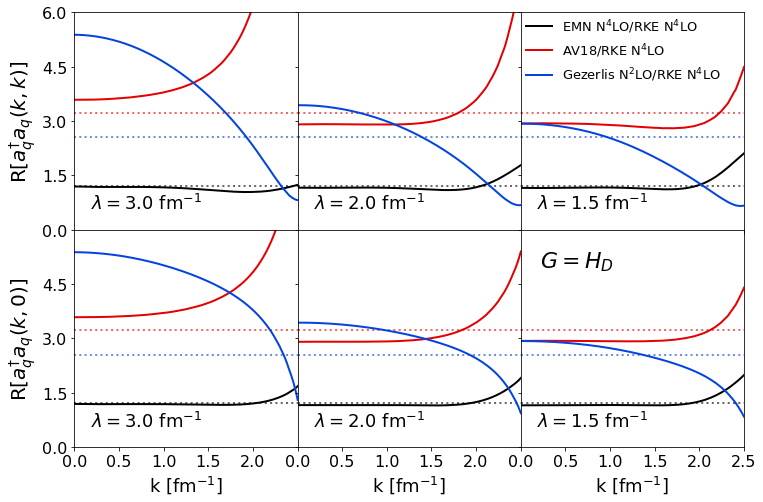

In [90]:
# # Ratios of the diagonal matrix elements of Wegner-evolved ataq for default kvnns and AV18 (RKE N4LO denominator)

# q = 3.0
# channel = '3S1'
# kvnns_num = [79, 6, 222]
# kvnn_den = 111
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = momentum_projection_ratios(q, channel, kvnn_den, kvnns_num, generator, lambda_array)

# # Add legend for kvnn pairs
# legend_size = 13
# legend_location = 'upper left'
# axs[0, len(lambda_array)-1].legend(loc=legend_location, borderaxespad=0.,
#                                    frameon=False, fontsize=legend_size)

# # Add label for generator
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                              prop=dict(size=generator_label_size), frameon=False)
# axs[1, 2].add_artist(anchored_text)

# # Add \lambda or \Lambda_BD labels to each sub-plot
# if generator == 'Block-diag':
#     lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# else:
#     lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 18
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_ratios_q%.2f_%s_kvnns_%d' % (q, channel, kvnn_den)
# for kvnn in kvnns_num:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

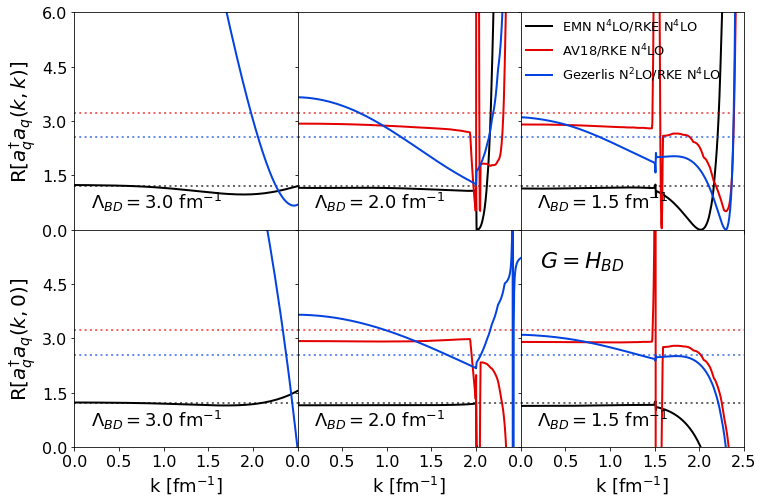

In [92]:
# Ratios of the diagonal matrix elements of Wegner-evolved ataq for default kvnns and AV18 (RKE N4LO denominator)

q = 3.0
channel = '3S1'
kvnns_num = [79, 6, 222]
kvnn_den = 111
generator = 'Block-diag'
lambda_array = np.array([3.0, 2.0, 1.5])
f, axs = momentum_projection_ratios(q, channel, kvnn_den, kvnns_num, generator, lambda_array)

# Add legend for kvnn pairs
legend_size = 13
legend_location = 'upper left'
axs[0, len(lambda_array)-1].legend(loc=legend_location, borderaxespad=0.,
                                   frameon=False, fontsize=legend_size)

# Add label for generator
generator_label = ff.generator_label_conversion(generator)
generator_label_size = 22
generator_label_location = 'upper left'
anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                             prop=dict(size=generator_label_size), frameon=False)
axs[1, 2].add_artist(anchored_text)

# Add \lambda or \Lambda_BD labels to each sub-plot
if generator == 'Block-diag':
    lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
else:
    lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
lambda_label_size = 18
lambda_label_location = 'lower left'
for i in range(2):
    for j, lamb in enumerate(lambda_array):
        anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
                                     prop=dict(size=lambda_label_size), frameon=False)
        axs[i, j].add_artist(anchored_text)

# Set file name
file_name = 'momentum_projection_ratios_q%.2f_%s_kvnns_%d' % (q, channel, kvnn_den)
for kvnn in kvnns_num:
    file_name += '_%d' % kvnn
file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# Save figure as .pdf
chdir('Figures/Operator_evolution')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

__Plot $r^2$ operator contours subtracting out initial operator $r_{\lambda}^2(k,k')-r_{\infty}^2(k,k')$__

In [46]:
def r2_diff_contours(kvnn, generators, lambda_array, contour_type='contourf'):
    """
    Plots SRG-evolved r^2 operators (subtracting out the initial operator) [fm^5] with respect to momentum [fm^-1].
    This is an m x n contour plot where m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    #factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    factor_array = np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Calculate initial operator
    initial_operator = op.r2_operator(k_array, k_weights, r_array, dr)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    #axes_max = 0.4
    axes_max = 10.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 0.1 # Step-size in labeling tick marks
    axes_stepsize = 2.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%.1f' % tick for tick in axes_ticks]
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
#     mx = 8e2
#     mn = -8e2
    mx = 2e1
    mn = -2e1
#     mx = 2.5e3
#     mn = -2.5e3
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ['%.0f' % tick for tick in levels_ticks]
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
#     color_style = 'jet'
    color_style = 'turbo'
    
    
    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
#                 H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
#                                                  lambda_bd=lamb)
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.5,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)
        
            # Calculate difference from evolved and initial operators
            operator_diff = (evolved_operator - initial_operator)
            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                operator_diff = operator_diff[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator_diff = operator_diff / row / col
        
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, axes_max)
        
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = operator_diff_int
        
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            # Use contourf
            if contour_type == 'contourf':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                       extend='both')
            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(k_array_int, k_array_int, d[generator][lamb], cmap=color_style, vmin=mn, 
                                         vmax=mx, rasterized=True)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [47]:
# # Contours of r^2 operator (subtracting out initial operator) under EMN N4LO (500 MeV) transformations
# kvnn = 79
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diff_contours(kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diff_contours_kvnn_%d_%s' % (kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [48]:
# # Contours of r^2 operator (subtracting out initial operator) under RKE N4LO (450 MeV) transformations
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diff_contours(kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# #generator_label_location = 'center right'
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# #lambda_label_location = 'lower right'
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diff_contours_kvnn_%d_%s' % (kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# #file_name += '.png'
# # TESTING
# file_name += '_with_k_factors.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [49]:
# # Contours of r^2 operator (subtracting out initial operator) under Gezerlis N2LO (1 fm) transformations
# kvnn = 222
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diff_contours(kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diff_contours_kvnn_%d_%s' % (kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [50]:
# # Contours of r^2 operator (subtracting out initial operator) under AV18 transformations
# kvnn = 6
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diff_contours(kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diff_contours_kvnn_%d_%s' % (kvnn, channel)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [51]:
# Fine-tune this function
#def r2_diag_diff(generator, kvnns, lambda_array):
def r2_diag_diff(generator, kvnns, lambda_array, r_min=0.005, r_max=30.2, dr=0.005):
    """
    Plots the difference in the diagonal elements of the r^2 operator [fm^5] between SRG transformations with
    respect to momentum [fm^-1]. This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Specify r_array
#     r_min = 0.005
#     r_max = 30.2
#     dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    #k_max = 5.0
    k_max = 0.2
#     k_max = 10.0
    xlim = [0.0, k_max]
    delta_r2_min = -1e3
    if generator == 'Block-diag':
        delta_r2_max = 4e3
    else:
        delta_r2_max = 3e3
#     delta_r2_min = -3.5e5
#     delta_r2_max = 3e5
#     delta_r2_min = -1e9
#     delta_r2_max = 1e9
    ylim = [delta_r2_min, delta_r2_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\Delta r^2_{\lambda}$' + '(k,k) [fm' + r'$^5$' + ']'
    y_label_size = 20
#     x_stepsize = 1.0
    x_stepsize = 0.05
    # x axis ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store difference in operators
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
#     blah = [(10, 10.0, 2.0, 120), (10, 30.0, 4.0, 120)]
#     for ele in blah:
#         kvnn = ele[0]
#         kmax = ele[1]
#         kmid = ele[2]
#         ntot = ele[3]
        
        # Store momentum and difference in here
        d[kvnn] = {}
#         d[kmax]={}
        #kmax=30.0
        kmax=10.0
        #kmid=4.0
        kmid=2.0
        ntot = 120
        
        # Load momentum and weights, and Hamiltonian
#         k_array, k_weights = lsp.load_momentum(kvnn, channel)
        k_array, k_weights = lsp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * 2/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        ntot = len(k_array)
#         H_initial = lsp.load_hamiltonian(kvnn, channel)
        H_initial = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        
#         d[kvnn]['k_array'] = k_array
#         d[kmax]['k_array']=k_array
        
        # Calculate initial operator
        initial_operator = op.r2_operator(k_array, k_weights, r_array, dr) / row / col
        k_array_int, initial_operator_int = ff.interpolate_matrix(k_array, initial_operator, k_max)
        
        # Loop over \lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator,
                                                 lamb=lambda_array[-1], lambda_bd=lamb)
            else:
#                 H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax=kmax, kmid=kmid, ntot=ntot, method='srg',
                                                 generator=generator, lamb=lamb)
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
            # Evolved operator and difference from initial
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix) / row / col
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, k_max)
            operator_diff = evolved_operator_int - initial_operator_int
            # Interpolate
#             k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, k_max)
            
            # Store difference in dictionary
            d[kvnn][lamb] = np.diag(operator_diff)
#             d[kvnn][lamb] = np.diag(operator_diff_int)
#             d[kmax][lamb] = np.diag(operator_diff)[:ntot]
            d[kvnn]['k_array'] = k_array_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda's and kvnns keeping track of indices
    for i, lamb in enumerate(lambda_array):
        for j, kvnn in enumerate(kvnns):
#         for j, ele in enumerate(blah):
#             kmax = ele[1]
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
#             curve_label = r'$k_{max}=%.1f$'%kmax
        
            axs[i].plot(d[kvnn]['k_array'], d[kvnn][lamb], color=curve_color, label=curve_label,
                        linestyle=curve_style, linewidth=curve_width)
#             axs[i].plot(d[kmax]['k_array'], d[kmax][lamb], color=curve_color, label=curve_label, 
#                         linestyle=curve_style, linewidth=curve_width)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].tick_params(labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        # Only set y-label for 1st sub-plot
        if i == 0:
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [52]:
# # Difference in r^2 operator far off-diagonal elements under Wegner SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# rmin=0.005
# #rmin = 0.01 # DOES NOT CHANGE ANYTHING
# rmax=30.2
# #rmax=20.0 # MASSIVE DIFFERENCE
# #rmax=40.0 # MASSIVE DIFFERENCE
# rstep=0.005
# #rstep=0.01 # DOES NOT CHANGE ANYTHING
# f, axs = r2_diag_diff(generator, kvnns_default, lambda_array, rmin, rmax, rstep)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'center right'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diag_diff_%s_kvnns' % generator
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# #file_name += '_rmin%.0e_rmax%.1f_rstep%.0e' % (rmin, rmax, rstep)
# file_name += '_diff_RKE_mesh.pdf'
# #file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [53]:
# # Difference in r^2 operator far off-diagonal elements under Wegner SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_diag_diff(generator, [79, 111], lambda_array)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'center right'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diag_diff_%s_kvnns' % generator
# for kvnn in [79, 111]:
#     file_name += '_%d' % kvnn
# file_name += '_diff_mesh.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [54]:
# # Difference in r^2 operator far off-diagonal elements under block-diagonal SRG transformations
# channel = '3S1'
# generator = 'Block-diag'
# lambda_array = np.array([3.0, 2.0, 1.5, 1.2])
# f, axs = r2_diag_diff(generator, kvnns_default, lambda_array)
# # f, axs = r2_diag_diff(generator, lambda_array)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'center right'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diag_diff_%s_kvnns' % generator
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [55]:
# # Difference in r^2 operator far off-diagonal elements under high cutoffs/AV18 Wegner SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5, 1.2])
# f, axs = r2_diag_diff(generator, (6, 900, 901), lambda_array)

# # Manually shift y-axis
# ylim = [-2000, 4000]
# for i in range(len(lambda_array)):
#     axs[i].set_ylim(ylim)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'center right'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_diag_diff_%s_kvnns' % generator
# for kvnn in (6, 900, 79):
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [56]:
# Fine-tune this function
# def r2_off_diag_diff(generator, lambda_array):
def r2_off_diag_diff(generator, kvnns, lambda_array):
    """
    Plots the difference in the far off-diagonal elements of the r^2 operator [fm^5] between SRG transformations 
    with respect to momentum [fm^-1]. This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Partial wave channel
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    #k_max = 5.0
    k_max = 0.4
#     k_max = 10.0
    xlim = [0.0, k_max]
    delta_r2_min = -1.5e3
    delta_r2_max = 3e3
#     delta_r2_min = -3.5e5
#     delta_r2_max = 3e5
#     delta_r2_min = -1e9
#     delta_r2_max = 1e9
    ylim = [delta_r2_min, delta_r2_max]
   
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\Delta r^2_{\lambda}$' + '(k,0) [fm' + r'$^5$' + ']'
    y_label_size = 20
#     x_stepsize = 1.0
    x_stepsize = 0.1
    # x axis ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store difference in operators
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
#     blah = [(10, 10.0, 2.0, 120), (10, 30.0, 4.0, 120)]
#     for ele in blah:
#         kvnn = ele[0]
#         kmax = ele[1]
#         kmid = ele[2]
#         ntot = ele[3]
        
        # Store momentum and difference in here
        d[kvnn] = {}
#         d[kmax]={}
        
        # Load momentum and weights, and Hamiltonian
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
#         k_array, k_weights = lsp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * 2/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        ntot = len(k_array)
        H_initial = lsp.load_hamiltonian(kvnn, channel)
#         H_initial = lsp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        
#         d[kvnn]['k_array'] = k_array
#         d[kmax]['k_array']=k_array
        
        # Calculate initial operator
        initial_operator = op.r2_operator(k_array, k_weights, r_array, dr) / row / col
        k_array_int, initial_operator_int = ff.interpolate_matrix(k_array, initial_operator, k_max)
        
        # Loop over \lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
#                 H_evolved = lsp.load_hamiltonian(kvnn, channel, kmax=kmax, kmid=kmid, ntot=ntot, method='srg',
#                                                  generator=generator, lamb=lamb)
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
            # Evolved operator and difference from initial
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix) / row / col
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, k_max)
            operator_diff = evolved_operator_int - initial_operator_int
            # Interpolate
#             k_array_int, operator_diff_int = ff.interpolate_matrix(k_array, operator_diff, k_max)
            
            # Store difference in dictionary
            d[kvnn][lamb] = operator_diff[:, 0]
#             d[kmax][lamb] = np.diag(operator_diff)[:ntot]
            d[kvnn]['k_array'] = k_array_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda's and kvnns keeping track of indices
    for i, lamb in enumerate(lambda_array):
        for j, kvnn in enumerate(kvnns):
#         for j, ele in enumerate(blah):
#             kmax = ele[1]
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
#             curve_label = r'$k_{max}=%.1f$'%kmax
        
            axs[i].plot(d[kvnn]['k_array'], d[kvnn][lamb], color=curve_color, label=curve_label,
                        linestyle=curve_style, linewidth=curve_width)
#             axs[i].plot(d[kmax]['k_array'], d[kmax][lamb], color=curve_color, label=curve_label, 
#                         linestyle=curve_style, linewidth=curve_width)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].tick_params(labelsize=axes_tick_size)
        
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Set axes labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        # Only set y-label for 1st sub-plot
        if i == 0:
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [57]:
# # Difference in r^2 operator far off-diagonal elements under Wegner SRG transformations
# channel = '3S1'
# generator = 'Wegner'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_off_diag_diff(generator, kvnns_default, lambda_array)
# # f, axs = r2_off_diag_diff(generator, lambda_array)

# # Add legend for kvnns on 1st sub-plot
# legend_size = 16
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     if generator == 'Block-diag':
#         # Labels the block-diagonal cutoff \Lambda_BD
#         lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#     else:
#         # Labels the evolution parameter \lambda
#         lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_off_diag_diff_%s_kvnns' % generator
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [58]:
def r2_contours(kvnn, generators, lambda_array, scale='log'):
    """
    Plots SRG-evolved r^2 operators [fm^5] with respect to momentum [fm^-1]. This is an m x n contour plot where 
    m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    scale : str, optional
        Colorbar scale ('log' or 'linear'). Default option is 'log'.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Calculate initial operator
    initial_operator = op.r2_operator(k_array, k_weights, r_array, dr)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    #axes_max = 0.4
    axes_max = 5.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    #axes_stepsize = 0.1 # Step-size in labeling tick marks
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%.1f' % tick for tick in axes_ticks]
    axes_tick_size = 18
    
    # Colorbar ticks, label, fontsize, and color scheme
    levels_number = 61
    if scale == 'log':
        mx = 6
        mn = 0
        levels = np.logspace(mn, mx, levels_number)
        levels_ticks = np.logspace(mn, mx, mx-mn+1)
        levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
        color_style = 'Blues'
    else:
        mx = 1e4
        #mx = 1e6
        mn = -1e4
        #mn = -1e6
        levels = np.linspace(mn, mx, levels_number)
        levels_ticks = np.linspace(mn, mx, 9)
        levels_ticks_strings = ['%.0f' % tick for tick in levels_ticks]
        color_style = 'turbo'
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)

            # Take only the upper sub-block if coupled-channel 
            if lsp.coupled_channel(channel):
                evolved_operator = evolved_operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            if scale == 'log': # Take absolute value for log-scale
                evolved_operator = abs( evolved_operator ) / row / col
            else:
                evolved_operator = evolved_operator / row / col
        
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, axes_max)
        
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = evolved_operator_int
        
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            if scale == 'log':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, norm=colors.LogNorm(),
                                       cmap=color_style, extend='both')
            else:
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style,
                                       extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [59]:
# # r^2 operator under SRG transformations with RKE N4LO 450 MeV (log-scale)
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_contours(kvnn, generators, lambda_array)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_contours_kvnn_%d_log_scale_zoomed_out.png' % kvnn

# # Save figure as .png
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [60]:
# # r^2 operator under SRG transformations with RKE N4LO 450 MeV (log-scale)
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_contours(kvnn, generators, lambda_array, scale='linear')

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# #file_name = 'r2_contours_kvnn_%d_linear_scale_zoomed_in.png' % kvnn
# file_name = 'r2_contours_kvnn_%d_linear_scale_zoomed_out.png' % kvnn

# # Save figure as .png
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [61]:
# Fine-tune this function
def r2_integrand_contours(kvnn, generator, lamb, eps=-2.22, lambda_bd=0.0, scale='linear'):
        
    channel = '3S1'
    # Load initial Hamiltonian, momentum, and weights
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    ntot = len(k_array)
    # The arrays below are used later to present a mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    #factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)

    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18

    # Limits of axes on contours (units are fm^-1)
    if scale == 'linear':
        axes_max = 1.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 0.25
    else:
        axes_max = 5.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)

    # Limits of colorbar (units are fm^6)
    if scale == 'linear':
        mx = 3000
        mn = -3000
        color_style = 'jet'
    else:
        mx = 1e2
        mn = 1e-7
        colorbar_norm_log = colors.LogNorm(vmin=mn, vmax=mx)
        color_style = 'Blues'

    # Size of figure
    figure_size = (4, 3.5) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_contours_kvnn_number_generator'
    file_name = 'r2_integrand_contours_kvnn%d_%s_eps%.2f_lamb%.1f' % (kvnn, generator, eps, lamb)
    if generator=='Block-diag':
        file_name += 'lambda_bd%.1f' % lambda_bd
    file_name += '_%s' % scale

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Evolved momentum projection operator
    operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)
    # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
    #operator = operator / row / col
    #operator = operator / np.pi
    
    psi = ob.wave_function(H_initial, eps=eps, U=U_matrix)
    psi_with_weights = psi * factor_array
    
    psi_row, psi_col = np.meshgrid(psi_with_weights, psi_with_weights)
    
    integrand = psi_row * operator * psi_col / row / col
    if scale == 'log':
        integrand = abs(integrand)
        
    # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    if scale == 'linear':
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, vmin=mn, vmax=mx,
                          rasterized=True)
    else:
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, norm=colorbar_norm_log,
                          rasterized=True)
                                         
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
                     
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks)
    # Switch from bottom to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    ax.set_xlabel(x_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks)
    ax.tick_params(labelsize=axes_tick_size)
    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=axes_label_size)
    
    generator_label_size = 17
    generator_label_location = 'upper right'
    generator_label = ff.generator_label_conversion(generator)
    generator_anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                                           prop=dict(size=generator_label_size))
    ax.add_artist(generator_anchored_text)

    # Add \lambda label to each sub-plot
    lambda_label_size = 17
    lambda_label_location = 'lower left'
    if generator == 'Block-diag':
        # Labels the block-diagonal cutoff \Lambda_BD
        lambda_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
    else:
        # Labels the evolution parameter \lambda
        lambda_label = ff.lambda_label_conversion(lamb)
    lambda_anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
    ax.add_artist(lambda_anchored_text)
    
    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

    return f, ax

In [62]:
# f, ax = r2_integrand_contours(79, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(222, 'Wegner', 1.5)
# f, ax = r2_integrand_contours(111, 'Wegner', 3.0, eps=-2.22, scale='log')
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5, eps=-2.22, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=3.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=2.0, scale='log')

# f, ax = r2_integrand_contours(111, 'Wegner', 3.0, eps=300.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Wegner', 1.5, eps=300.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=300.0, lambda_bd=3.0, scale='log')
# f, ax = r2_integrand_contours(111, 'Block-diag', 1.0, eps=300.0, lambda_bd=2.0, scale='log')

# f, ax = r2_integrand_diff_contours(79, 111, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(79, 222, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(111, 222, 'Wegner', 1.5, eps=-2.22, scale='linear')
# f, ax = r2_integrand_diff_contours(79, 111, 'Block-diag', 1.0, eps=-2.22, lambda_bd=2.0, scale='linear')

__Plot SRG transformations $\delta U_{\lambda}(k,k')=U_{\lambda}(k,k')-\mathbb{1}$__

In [63]:
# Check this function
def unitary_transformation_contours(channel, kvnns, generators, lamb, lambda_bd=2.0, contour_type='contourf'):
    """
    Plots SRG unitary transformations [fm^3] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of generators and n is the size of kvnns.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    contour_type : str, optional
        If 'contourf' uses matplotlib's contourf plotting function. Otherwise, uses matplotlib's pcolormesh.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = len(generators)
    col_number = len(kvnns)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 5.0
    axes_lim = [0.0, axes_max]
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    levels_number = 61
    # Linear scale settings
    if kvnns[0] in [6, 900, 901, 902]: # Set higher value for harder potentials
        mx = 0.6
        mn = -0.6
    else:
        mx = 0.2
        mn = -0.2
    colorbar_norm = colors.Normalize(vmin=mn, vmax=mx)
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ['%.2f' % tick for tick in levels_ticks]
    # Colorbar label
    colorbar_label = '[fm' +r'$^3$' + ']'
    colorbar_label_size = 20
    colorbar_tick_size = 18

    # Color scheme for contour plots
    color_style = 'turbo'

    
    # --- Load transformations --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and transformation in here
        d[kvnn] = {}
        
        # Load momentum and weights, initial Hamiltonian, and build factor_array for dividing out momentum and 
        # weights
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        H_initial = lsp.load_hamiltonian(kvnn, channel)
        ntot = len(k_array)
        #factor_array = k_array * np.sqrt(k_weights) * 2.0/np.pi
        factor_array = np.sqrt(k_weights) * 2.0/np.pi
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Loop over generators
        for generator in generators:
        
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lambda_bd)
            else:
                H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)[:ntot, :ntot]
        
            # Subtract out identity matrix and divide out momentum and weights
            I = np.eye(ntot, ntot)
            delta_U = (U_matrix - I) / row / col
        
            # Interpolate and store in dictionary
            k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max)
        
            # Store in dictionary with kvnn, 'k_array', and generator as keys 
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][generator] = delta_U_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators keeping track of indices
    for i, generator in enumerate(generators):
        # Loop over kvnns keeping track of indices
        for j, kvnn in enumerate(kvnns):
            
            if contour_type == 'contourf':
                c = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][generator], levels,
                                       norm=colorbar_norm, cmap=color_style, extend='both')

            # Otherwise use pcolormesh
            else:
                c = axs[i, j].pcolormesh(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][generator],
                                         cmap=color_style, vmin=mn, vmax=mx, rasterized=True)

                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axes
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set tick size and labels
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [64]:
# # Contours of EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm) under SRG transformations
# channel = '3S1'
# lamb = 1.5
# lambda_bd = 2.0
# f, axs = unitary_transformation_contours(channel, kvnns_default, generators, lamb, lambda_bd)

# # Add kvnn label to each subplot on the bottom row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[len(generators)-1, j].add_artist(anchored_text)

# # Add generator labels to 1st sub-plots on the 1st column
# generator_label_size = 20
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_contours_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_lamb%.1f_Lamb%.1f' % (lamb, lambda_bd)
# file_name = ff.replace_periods_with_commas(file_name)
# #file_name += '.png'
# file_name += '_with_k_factors.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [65]:
# # Contours of high cutoff LO potentials under SRG transformations
# channel = '3S1'
# lamb = 1.2
# lambda_bd = 2.0
# f, axs = unitary_transformation_contours(channel, kvnns_high_cutoffs, generators, lamb, lambda_bd)

# # Add kvnn label to each subplot on the bottom row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns_high_cutoffs):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[len(generators)-1, j].add_artist(anchored_text)

# # Add generator labels to 1st sub-plots on the 1st column
# generator_label_size = 20
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_contours_kvnns'
# for kvnn in kvnns_high_cutoffs:
#     file_name += '_%d' % kvnn
# file_name += '_lamb%.1f_Lamb%.1f' % (lamb, lambda_bd)
# file_name = ff.replace_periods_with_commas(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Test factorization by calculating ratio of SRG transformations $|\frac{U(k_i,q)}{U(k_0,q)}|$__

In [66]:
# Fine-tune this function
def unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd=0.0):
    """
    Plots the ratio of SRG transformations [fm^3] with respect to momentum [fm^-1] for k = k_points in the numerator
    and k = k_0 in the denominator, and k' = q_array. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0, q) in the denominator [fm^-1].
    k_points : 1-D ndarray
        Array of momentum values for U(k_points, q) in the numerator [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
     
    # --- Set-up --- #
    
    # Load momentum and weights
    k_array, k_weights = lsp.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Load initial and evolved Hamiltonians
    H_initial = lsp.load_hamiltonian(kvnn, channel)
    H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd)
    
    # Calculate unitary transformation and divide out momenta and weights
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved) / row / col
    
    # Obtain U(k_0,q) array
    k_0_index = op.find_q_index(k_0, k_array)
    U_k0_array = U_matrix[k_0_index, :ntot]
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, 5.0]
    ylim = [1e-1, 1e1]
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = '|U(' + r'$k_i,q$' + ')/U(' + r'$k_0,q$' + ')|'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Obtain U(k_i,q) arrays --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over k_i in k_points
    for k_i in k_points:
        
        k_i_index = op.find_q_index(k_i, k_array)
        U_ki_array = U_matrix[k_i_index, :ntot]
        
        # Calculate ratio and store in dictionary with k_i as the key
        d[k_i] = abs(U_ki_array / U_k0_array)
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over k_points and keep track of k_points index
    for i, k_i in enumerate(k_points):
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = r'$k_i=%.1f$' % k_i + ' fm' + r'$^{-1}$'
        
        # Add curve to figure
        ax.semilogy(k_array, d[k_i], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, 0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, 0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax    

In [67]:
# # SRG transformation ratios for RKE N4LO 450 MeV with block-diagonal generator
# k_0 = 0.1
# kvnn = 111
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

In [68]:
# # SRG transformation ratios for RKE N4LO 450 MeV with Wegner generator
# k_0 = 0.1
# kvnn = 111
# channel = '3S1'
# generator = 'Wegner'
# lamb = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [69]:
# # SRG transformation ratios for EMN N4LO 500 MeV with block-diagonal generator
# k_0 = 0.1
# kvnn = 79
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [70]:
# # SRG transformation ratios for Gezerlis 1 fm with block-diagonal generator
# k_0 = 0.1
# kvnn = 222
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [71]:
# # SRG transformation ratios for Gezerlis 1 fm with band-diagonal generator
# k_0 = 0.1
# kvnn = 222
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.5
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [72]:
# # SRG transformation ratios for AV18 with block-diagonal generator
# k_0 = 0.1
# kvnn = 6
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# ax.set_ylim([1e-1, 1e1])

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [73]:
# # SRG transformation ratios for AV18 with band-diagonal generator
# k_0 = 0.1
# kvnn = 6
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.5
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# ax.set_ylim([1e-1, 1e1])

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [74]:
# # SRG transformation ratios for non-local LO \Lambda=9 fm^-1 potential with block-diagonal generator
# k_0 = 0.1
# kvnn = 901
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [75]:
# # SRG transformation ratios for RKE N4LO 550 MeV with block-diagonal generator
# k_0 = 0.1
# kvnn = 113
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [76]:
def unitary_transformation_ratios_vary_kvnn(k_0, k_points, kvnns, channel, generator, lamb, lambda_bd=0.0):
    """
    Plots the ratio of SRG transformations [fm^3] with respect to momentum [fm^-1] for k = k_points in the numerator
    and k = k_0 in the denominator, and k' = q_array. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0, q) in the denominator [fm^-1].
    k_points : 1-D ndarray
        Array of momentum values for U(k_points, q) in the numerator [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
     
    # --- Set-up --- #
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    xlim = [0.0, 5.0]
    ylim = [1e-1, 1e1]
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0
    # x axis ticks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_label = '|U(' + r'$k_i,q$' + ')/U(' + r'$k_0,q$' + ')|'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    
    # --- Obtain U(k_i,q) arrays --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Load momentum and weights
        k_array, k_weights = lsp.load_momentum(kvnn, channel)
        # Number of points in momentum array
        ntot = len(k_array)
        # Use factor_array to divide out momenta/weights for mesh-independent result
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
        row, col = np.meshgrid(factor_array, factor_array)
    
        # Load initial and evolved Hamiltonians
        H_initial = lsp.load_hamiltonian(kvnn, channel)
        H_evolved = lsp.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
        # Calculate unitary transformation and divide out momenta and weights
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved) / row / col
    
        # Obtain U(k_0,q) array
        k_0_index = op.find_q_index(k_0, k_array)
        U_k0_array = U_matrix[k_0_index, :ntot]
        
        d[kvnn]['k_array'] = k_array
    
        # Loop over k_i in k_points
        for k_i in k_points:
        
            k_i_index = op.find_q_index(k_i, k_array)
            U_ki_array = U_matrix[k_i_index, :ntot]
        
            # Calculate ratio and store in dictionary with k_i as the key
            d[kvnn][k_i] = abs(U_ki_array / U_k0_array)
            

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, kvnn in enumerate(kvnns):
        # Loop over k_points and keep track of k_points index
        for j, k_i in enumerate(k_points):
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = r'$k_i=%.1f$' % k_i + ' fm' + r'$^{-1}$'
            
            # Add curve to figure
            axs[i].semilogy(d[kvnn]['k_array'], d[kvnn][k_i], color=curve_color, label=curve_label, 
                            linestyle=curve_style, linewidth=curve_width)
            
        # Shade gray from 0 to \lambda or \Lambda_BD value on plot
        if generator == 'Block-diag':
            axs[i].fill_betweenx(ylim, 0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
        else:
            axs[i].fill_betweenx(ylim, 0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # On the left column, label y-axis
        if i == 0:
                                      
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].xaxis.set_ticklabels(x_ticks)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
                    
        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=x_label_size)

        # Enlarge axes tick marks
        axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [77]:
# # SRG transformation ratios for default kvnns with Wegner generator
# k_0 = 0.1
# channel = '3S1'
# generator = 'Wegner'
# lamb = 2.0
# f, axs = unitary_transformation_ratios_vary_kvnn(k_0, k_points, kvnns_default, channel, generator, lamb)

# # Add labels for k_i values
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns_default)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False,
#                                  fontsize=legend_size)

# # Add kvnn labels to each sub-plot
# kvnn_size = 16
# kvnn_location = 'lower right'
# for i, kvnn in enumerate(kvnns_default):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_location, prop=dict(size=kvnn_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_%s_%s' % (channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Plot deuteron wave function in coordinate-space $\psi_d(r)$__

In [78]:
def hankel_transformation(channel, k_array, k_weights, r_array):
    """
    <r|klm> matrix for given partial wave channel. If len(r_array) = m and len(k_array) = n, then this function 
    returns an m x n matrix.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    k_weights : 1-D ndarray
        Momentum weights [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^-3].

    """
        
    
    # L = 0 (0th spherical Bessel function)
    if channel[1] == 'S':
        L = 0
    # L = 1
    elif channel[1] == 'P':
        L = 1
    # L = 2
    elif channel[1] == 'D':
        L = 2
        
    # r_array row vectors and k_array column vectors where both grids are n x m matrices
    k_cols, r_rows = np.meshgrid(k_array, r_array)
    k_weights_cols, _ = np.meshgrid(k_weights, r_array)
        
    M = 2/np.pi * k_cols**2 * k_weights_cols * spherical_jn(L, k_cols * r_rows)

    return M

In [79]:
def deuteron_wave_func_coord_space(kvnns, generator, lamb, lambda_bd=0.0, eps=-2.22):
    """
    Plots the deuteron wave function [fm^3] with respect to relative distance [fm] for the initial SRG-evolved
    wave function.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
     
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Figure size
    row_number = 1
    col_number = 2
    width = 4
    height = 4
    figure_size = (width * col_number, height * row_number)
    
    # Axes limits
    xlim = [0.0, 5.0]
    ylim = [-0.2, 0.5]
        
    # Axes labels and fontsize
    x_label = 'r [fm]'
    x_label_size = 18
    y_label = r'$\psi_d(r)$' + ' [fm' + r'$^{-3/2}$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate coordinate-space wave functions --- #
    
    # Initialize dictionary
    d = {}
    
    # Keys for dictionary
    channels = ['3S1', '3D1']
    resolution = ['initial', 'evolved']
    
    for kvnn in kvnns:
        
        # Load momentum and weights
        k_array, k_weights = lsp.load_momentum(kvnn, '3S1')
        # Number of points in momentum array
        ntot = len(k_array)
        # Use factor_array to divide out momenta/weights for mesh-independent result
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    
        # Load initial and evolved Hamiltonians
        H_initial = lsp.load_hamiltonian(kvnn, '3S1')
        H_evolved = lsp.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
        # Calculate unitary transformation
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
    
        # The momentum-space wave functions are negative for these cases -> switch to positive for presentation
        if kvnns[0] in [6, 900, 901, 902]:
            sign = -1
        else:
            sign = 1
        # Calculate initial and evolved wave functions dividing out momenta/weights
        psi_initial = sign * ob.wave_function(H_initial, eps) / factor_array
        psi_evolved = sign * ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
    
        # Load Hankel transformations
        hank_trans_3S1 = hankel_transformation('3S1', k_array, k_weights, r_array)
        hank_trans_3D1 = hankel_transformation('3D1', k_array, k_weights, r_array)
        
        d[kvnn] = {}
    
        # Loop over keys
        for channel in channels:
            d[kvnn][channel] = {}
            for res in resolution:
                if channel == '3S1':
                    if res == 'initial':
                        d[kvnn][channel][res] = hank_trans_3S1 @ psi_initial[:ntot]
                    else:
                        d[kvnn][channel][res] = hank_trans_3S1 @ psi_evolved[:ntot]
                else:
                    if res == 'initial':
                        d[kvnn][channel][res] = hank_trans_3D1 @ psi_initial[ntot:]
                    else:
                        d[kvnn][channel][res] = hank_trans_3D1 @ psi_evolved[ntot:]
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Inset plot for spurious bound state in initial panel
    if 901 in kvnns or 902 in kvnns:
        
        # These are in unitless percentages of the figure size
        # The coordinates here give the upper right of the 1st subplot
        left, bottom, width, height = [0.365, 0.59, 0.13, 0.26]
        inset_ax = f.add_axes([left, bottom, width, height])
    
    # Loop over kvnns, channels, and initial/evolved keeping track of indices
    for i, res in enumerate(resolution):
        
        # Add horizontal line at psi_d = 0 fm^-3/2
        axs[i].axhline(0.0, color='gray', alpha=0.4)
        
        for j, channel in enumerate(channels):
            for k, kvnn in enumerate(kvnns):
                
                curve_color = ff.xkcd_colors(k)
                if channel == '3S1':
                    curve_style = 'solid'
                    curve_label = ff.kvnn_label_conversion(kvnn)
                else:
                    curve_style = 'dashed'
                    curve_label = ''

                # Add curve to figure
                axs[i].plot(r_array, d[kvnn][channel][res], color=curve_color, label=curve_label, 
                            linestyle=curve_style, linewidth=curve_width)
                

                # Inset plot (only if we have a spurious state potential)
                if (901 in kvnns or 902 in kvnns) and i == 0:
                    inset_ax.plot(r_array, d[kvnn][channel][res], color=curve_color, label=curve_label, 
                                  linestyle=curve_style, linewidth=curve_width)
                    inset_ax.set_xlim([0.0, 2.0]) # Shortened x-axis
                    inset_ax.set_ylim([-0.7, 0.5]) # Extended y-axis to see negative drop
    
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
    
        # Set x-axis labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        
        if i == 0:
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
            # Prevent overlapping x-axis tick marks
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Enlarge axes tick marks
        axs[i].tick_params(labelsize=axes_tick_size)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [80]:
# # Deuteron coordinate-space wave functions for AV18, RKE N4LO, EMN N4LO with Wegner generator
# kvnns = (6, 111, 79)
# generator = 'Wegner'
# lamb = 1.5
# f, axs = deuteron_wave_func_coord_space(kvnns, generator, lamb)

# # Add legend for wave function components and SRG-evolution
# legend_size = 14
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [81]:
# # Deuteron coordinate-space wave functions for AV18, RKE N4LO, EMN N4LO with block-diagonal generator at
# # \Lambda_BD = 2 fm^-1
# kvnns = (6, 111, 79)
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.00
# f, axs = deuteron_wave_func_coord_space(kvnns, generator, lamb, lambda_bd)

# # Add legend for wave function components and SRG-evolution
# legend_size = 14
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\Lambda_{BD}=%.1f$' % lambda_bd + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lambda_bd)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [82]:
# # Deuteron coordinate-space wave functions for AV18, RKE N4LO, EMN N4LO with block-diagonal generator at
# # \Lambda_BD = 1.5 fm^-1
# kvnns = (6, 111, 79)
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 1.50
# f, axs = deuteron_wave_func_coord_space(kvnns, generator, lamb, lambda_bd)

# # Add legend for wave function components and SRG-evolution
# legend_size = 14
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\Lambda_{BD}=%.1f$' % lambda_bd + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lambda_bd)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [83]:
# # Deuteron coordinate-space wave functions for EMN N4LO, RKE N4LO, Gezerlis N2LO with block-diagonal generator at
# # \Lambda_BD = 2 fm^-1
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, axs = deuteron_wave_func_coord_space(kvnns_default, generator, lamb, lambda_bd)

# # Add legend for wave function components and SRG-evolution
# legend_size = 12
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\Lambda_{BD}=%.1f$' % lambda_bd + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lambda_bd)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [84]:
# # Deuteron coordinate-space wave functions for EMN N4LO, RKE N4LO, Gezerlis N2LO with Wegner generator at
# # \lambda = 1.2 fm^-1
# generator = 'Wegner'
# lamb = 1.2
# f, axs = deuteron_wave_func_coord_space(kvnns_default, generator, lamb)

# # Add legend for wave function components and SRG-evolution
# legend_size = 12
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns_default:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [85]:
# # Deuteron coordinate-space wave functions for high cutoff potentials with Wegner generator at \lambda = 1.2 fm^-1
# generator = 'Wegner'
# lamb = 1.2
# f, axs = deuteron_wave_func_coord_space((6, 900, 901), generator, lamb)

# # Add legend for wave function components and SRG-evolution
# legend_size = 14
# legend_location = 'upper right'
# axs[1].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in (6, 900, 901):
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [86]:
# # Deuteron coordinate-space wave functions for high cutoff potentials with T_rel generator at \lambda = 1.2 fm^-1
# generator = 'T'
# lamb = 1.2
# f, axs = deuteron_wave_func_coord_space((6, 900, 901), generator, lamb)

# # Shift y-axis down a bit
# for i in range(2):
#     axs[i].set_ylim([-0.7, 1.1])

# # Add legend for wave function components and SRG-evolution
# legend_size = 15
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in (6, 900, 901):
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [87]:
# # Spurious bound state coordinate-space wave functions for high cutoff potentials with Wegner generator at \lambda = 1.2 fm^-1
# generator = 'Wegner'
# lamb = 1.2
# #f, axs = deuteron_wave_func_coord_space([901], generator, lamb, eps=-2000)

# # TESTING
# f, axs, d, r_array = deuteron_wave_func_coord_space([901], generator, lamb, eps=-2000)
# psi_3s1_0 = d[901]['3S1']['initial']
# psi_3d1_0 = d[901]['3D1']['initial']
# psi_3s1_s = d[901]['3S1']['evolved']
# psi_3d1_s = d[901]['3D1']['evolved']
# for i, r in enumerate(r_array):
#     line = '{:>15.5f}{:>15.5e}{:>15.5e}{:>15.5e}{:>15.5e}'.format(r,psi_3s1_0[i],psi_3d1_0[i],psi_3s1_s[i],
#                                                                   psi_3d1_s[i])
#     print(line)

# # Shift y-axis a bit
# for i in range(2):
#     axs[i].set_xlim([0.0, 10.0])
#     axs[i].set_ylim([-2.5, 0.5])
# axs[0].set_ylabel(r'$\psi_s(r)$' + ' [fm' + r'$^{-3/2}$' + ']', fontsize=20)

# # Add legend for wave function components and SRG-evolution
# legend_size = 16
# legend_location = 'center right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'center right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'spurious_wave_func_coord_space_kvnns'
# for kvnn in (6, 900, 901):
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)